# RAW Standard Input - fMRI INR

## Dependencies

In [36]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
from nilearn.image import index_img
from torch.utils.data import DataLoader, Subset
import random

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [38]:
###- DS LOCATION CONFIRMATION -###

file_path = "/home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii"

# verify the file exists
if os.path.exists(file_path):
    print(f"YES! File found at: {file_path}")
else:
    print(f"Error: File not found at: {file_path}")
    
# loads ds
fmri = nib.load(file_path)

YES! File found at: /home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii


## Volume and Slice Selection

(91, 109, 91, 1200)


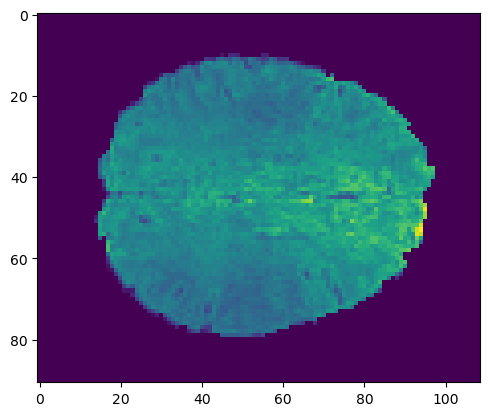

In [39]:
###- GET VOLUME AT TIMEPOINT, GET SLICE FROM VOLUME -###

print(fmri.shape)

# sets timepoint (out of 1200)
timepoint = 50 

# gets volume (instantiates 3D brain at timepoint)
single_volume = index_img(fmri, timepoint)
arr = single_volume.get_fdata()

# takes zth slice of volume (slice/image depth)
z_idx = [30,40,50,60,70]
slice = arr[:,:, z_idx[2]]

plt.imshow(slice)

## Normalization

-4.463201462811106 5.730761050590585e-17 5.128954352209998 (91, 109)


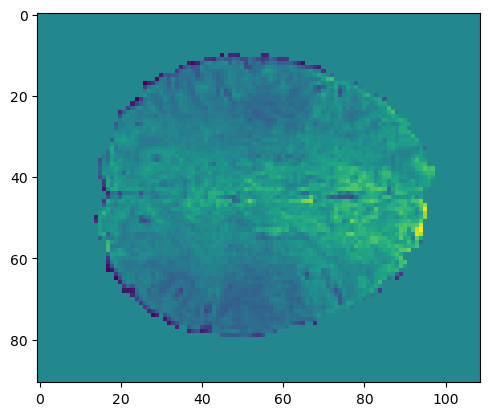

In [40]:
###- NORMALIZE SLICES -###

# only takes slices with intensity (everything but bg)
nonzero = slice[slice > 0]

# takes only black spaces (all bg)
back = slice == 0

# takes the mean and standard deviation of the brain component
m_, std_ = nonzero.mean(), nonzero.std()

# normalize 
norm_slice = (slice - m_) / std_
norm_slice[back] = 0
print(norm_slice.min(), norm_slice.mean(), norm_slice.max(), norm_slice.shape)
np.save('ground_truth.npy', norm_slice)
min_val = norm_slice.min()
max_val = norm_slice.max()

# display normalized slice
plt.imshow(norm_slice)

## Save Image

0 255 (91, 109)
109 91


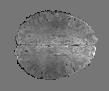

In [41]:
###- SAVE IMAGE -###

# stretch the values to fill the 0-255 range for the image
scaled_slice = 255 * (norm_slice - min_val) / (max_val - min_val)

# convert the scaled data to unsigned 8-bit integers 
image_array = scaled_slice.astype(np.uint8)
print(image_array.min(), image_array.max(), image_array.shape)

# create an image from the array and save it
img = Image.fromarray(image_array)
img.save('ground_truth.jpg')

W, H = img.size

print(W,H)

# preview image
img.show()


## Dataframe

In [42]:
###- BUILD DATAFRAME -###

# create slice array
bw_array = norm_slice.T  # transpose to (height, width)

# configure dimensions 
height, width = bw_array.shape
print(f"Shape of transposed slice: {bw_array.shape}")

# create coordinate grids
x_coords, y_coords = np.meshgrid(np.arange(height), np.arange(width))

# flatten everything
x_flat = x_coords.ravel()
y_flat = y_coords.ravel()
intensity_flat = bw_array.ravel()

# build df
min_int = np.min(intensity_flat)
max_int = np.max(intensity_flat)
print(max_int)
print(min_int)
df = pd.DataFrame({
    "x_pos": x_flat/(height-1),
    "y_pos": y_flat/(width-1),
    # [0 to 1] standardization    
    "intensity": intensity_flat
})

df.head()


Shape of transposed slice: (109, 91)
5.128954352209998
-4.463201462811106


,x_pos,y_pos,intensity
0,0.000000,0.0,0.0
1,0.009259,0.0,0.0
2,0.018519,0.0,0.0
3,0.027778,0.0,0.0
4,0.037037,0.0,0.0


## Model Definition

In [43]:
###- INR IMAGE ARCHITECTURE -###

class fMRI_INRModel(torch.nn.Module):
    # nn constructor
    def __init__(self, input_size, hidden_size = 256, output_size = 1, num_hidden = 4):
        super(fMRI_INRModel, self).__init__()
        # input - 2 - x,y
        # hidden_size - 256 - num of hidden neurons
        # output - 1 - intensity
        # num_hidden - 4 - num of hidden layers

        # creates first fully-connected layer
        self.input = torch.nn.Linear(input_size, hidden_size)

        # builds hidden network layers
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)   

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)

        return x

## Dataset Definition

In [44]:
#Dataset where input is simply [x,y] tensor
class ImageINRDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[['intensity']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Training

In [45]:
# creates a seed used to randomize training pixel grid
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    
    # if you are using multi-GPU, these lines ensure deterministic results
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"SEED SET TO: {seed}")

In [47]:
###- MAIN TRAINING LOOP -###

def train(num_freq, model_type, model_file='checkpoint.pth', loss_file='losses', freq_file='freq.pkl', visualize_split_flag=True):
    seed_everything(16)
    if model_type == 'standard':
        data = ImageINRDataset(df)
        model = fMRI_INRModel(input_size = 2).to(device)
    else:
        print('Invalid model_type specified.')
        return

    
    #--- DEV SET SPLIT ---#

    # gets ds size (expected 9919)
    ds_size = len(data)
    # indexes length of ds
    indices = list(range(ds_size))

    # randomizes indices
    np.random.shuffle(indices)
    
    # calculates size of training set (80% of full set)
    train_split = int(np.floor(0.8 * ds_size))
    
    # calculates size of validation set (10% of full set)
    val_split = int(np.floor(0.9 * ds_size))

    # 0 - train_split .. (80%)
    train_indices = indices[:train_split]
    # train_split - val_split .. (10%)
    val_indices = indices[train_split:val_split]
    # val_split - END .. (10%)
    test_indices = indices[val_split:]

    def visualize_split(full_df, train_indices):
        # pixel grid of the training dataset
        train_df = full_df.iloc[train_indices]

        # init figure
        plt.figure(figsize=(12, 6))
        
        # plots ALL pixels 
        plt.subplot(1, 2, 1)
        plt.scatter(full_df['x_pos'], full_df['y_pos'], s=1, alpha=0.5)
        plt.title(f'All Brain Pixels ({len(full_df)} points out of {len(full_df)})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.gca().invert_yaxis()
        plt.axis('equal')
    
        # plots ONLY TRAINING pixels
        plt.subplot(1, 2, 2)
        plt.scatter(train_df['x_pos'], train_df['y_pos'], s=1, alpha=0.5, color='orange')
        plt.title(f'Training Set Pixels ({len(train_df)} points out of {len(full_df)})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.gca().invert_yaxis()
        plt.axis('equal')

        # displays figure
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    # shows comparison when set to True
    if visualize_split_flag:
        visualize_split(data.dataframe, train_indices)

    # creates subsets
    train_dataset = Subset(data, train_indices)
    val_dataset = Subset(data, val_indices)
    test_dataset = Subset(data, test_indices) # TEST - *not used in training

    print(f"DS SPLIT: {len(train_dataset)} TRAIN, {len(val_dataset)} VAL, {len(test_dataset)} TEST")

    
    #--- TRAINING ---#

    train_dataloader = DataLoader(train_dataset, batch_size=8192, shuffle=True,)
    valid_dataloader = DataLoader(val_dataset, batch_size=8192, shuffle=False,)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    patience = 40  
    epochs_no_improve = 0
    best_val_loss = float('inf')
    print(f'PATIENCE: {patience}')
    
    train_losses = []
    valid_losses = []

    num_epochs = 300

    for epoch in tqdm(range(num_epochs)):
        model.train()  
        
        running_train_loss = 0.0
        
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

                 
        #--- VALIDATION ---#
        
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(valid_dataloader.dataset)
        valid_losses.append(epoch_val_loss)

        if (epoch + 1) % 30 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }

        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            print(f"Best validation loss: {best_val_loss:.6f}")
            break

        torch.save(checkpoint, model_file)

    print(f"\nSaving loss histories to '{loss_file}'...")
    loss_data = {
        'train_losses': train_losses,
        'valid_losses': valid_losses
    }
    with open(loss_file, 'wb') as f:
        pickle.dump(loss_data, f)
    print("Save complete.")
        
    return train_losses, valid_losses



SEED SET TO: 16


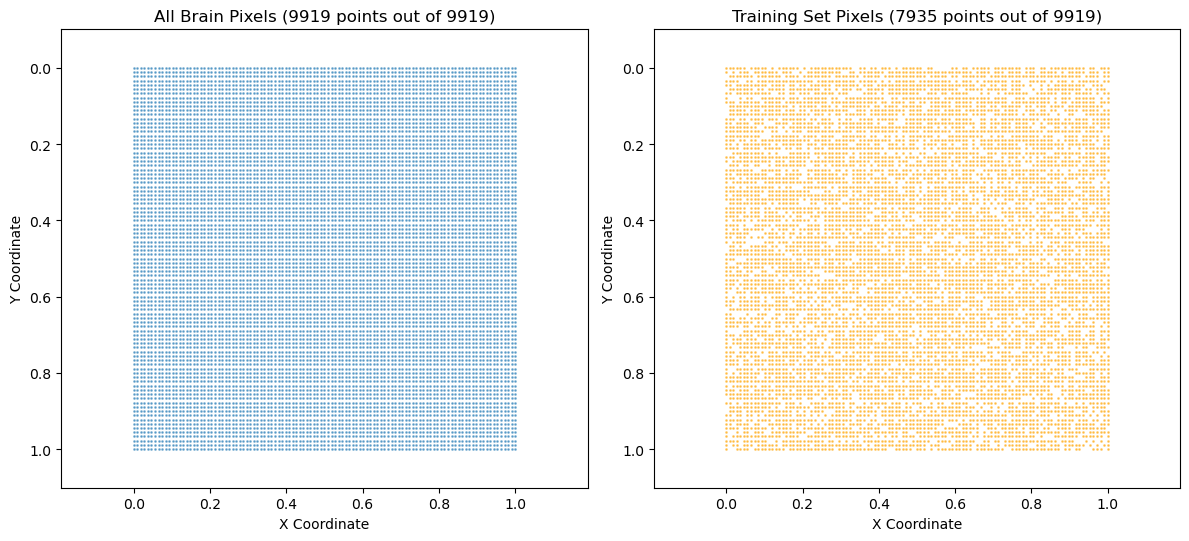

DS SPLIT: 7935 TRAIN, 992 VAL, 992 TEST
PATIENCE: 40


 10%|█         | 30/300 [00:05<01:01,  4.37it/s]

Epoch 30/300, Train Loss: 0.403531, Val Loss: 0.382219


 20%|██        | 60/300 [00:11<00:43,  5.57it/s]

Epoch 60/300, Train Loss: 0.399066, Val Loss: 0.378889


 30%|███       | 90/300 [00:17<00:40,  5.13it/s]

Epoch 90/300, Train Loss: 0.398689, Val Loss: 0.378221


 40%|████      | 120/300 [00:23<00:35,  5.05it/s]

Epoch 120/300, Train Loss: 0.398191, Val Loss: 0.378284


 50%|█████     | 150/300 [00:29<00:36,  4.07it/s]

Epoch 150/300, Train Loss: 0.396973, Val Loss: 0.377938


 60%|██████    | 180/300 [00:35<00:23,  5.18it/s]

Epoch 180/300, Train Loss: 0.399927, Val Loss: 0.378767


 63%|██████▎   | 188/300 [00:37<00:22,  5.03it/s]

Early stopping triggered after 40 epochs with no improvement.
Best validation loss: 0.377035

Saving loss histories to 'headshot_standard'...
Save complete.


([0.46603816747665405,
  0.459845632314682,
  0.45744773745536804,
  0.45418471097946167,
  0.44983458518981934,
  0.44479089975357056,
  0.4403715133666992,
  0.43791070580482483,
  0.43785709142684937,
  0.433272123336792,
  0.4323439300060272,
  0.43019914627075195,
  0.4293813109397888,
  0.42813557386398315,
  0.4272530674934387,
  0.42533156275749207,
  0.4245529770851135,
  0.4226115345954895,
  0.42133548855781555,
  0.4194153845310211,
  0.41776028275489807,
  0.41585761308670044,
  0.41356268525123596,
  0.4116377532482147,
  0.40965375304222107,
  0.40801718831062317,
  0.40678679943084717,
  0.405501127243042,
  0.40477946400642395,
  0.4035307765007019,
  0.4022614359855652,
  0.4012843072414398,
  0.40118253231048584,
  0.40148428082466125,
  0.4022952616214752,
  0.4038093090057373,
  0.4048116207122803,
  0.4006514251232147,
  0.4021388590335846,
  0.401521772146225,
  0.4010271430015564,
  0.4008692800998688,
  0.4010886251926422,
  0.40068188309669495,
  0.40032181143

In [48]:
train(num_freq = 1, model_type = 'standard', model_file ='RAW_standard.pth', loss_file = 'loss_standard')

## Visualization

torch.Size([9919, 1]) 109 91
min max of image tensor(-0.3544) tensor(0.5594) <class 'torch.Tensor'>
real diff from df tensor(0.3778)
The image resolution is: 109x91
reconstructed


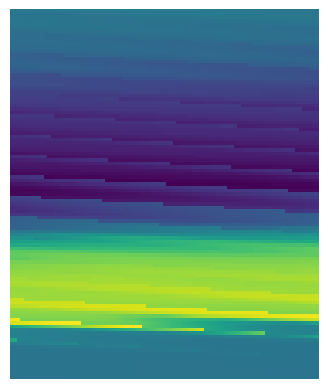

gt


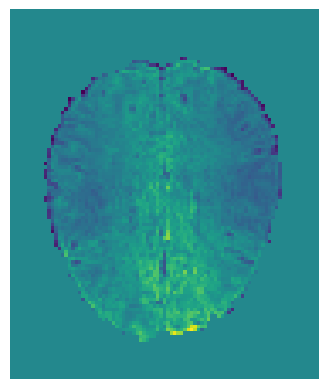

dif


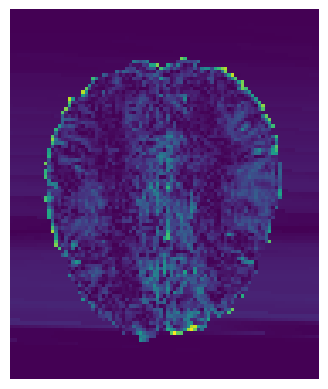

In [51]:
model = fMRI_INRModel(input_size = 2)


# define path to model checkpoint 
path = './STANDARD_raw.pth' 
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)  # shape: (H, W)

X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)

with torch.no_grad():
    Y = model(X) 

image = Y.reshape(W, H, 1) # [9019, 1] -> [91, 109, 1]
print(Y.shape, W, H)
print('min max of image',image.min(), image.max(), type(image))

gt_df = torch.Tensor(df.intensity).reshape(W,H,1)
gt_df_diff = torch.sum(torch.abs(gt_df - image), axis=2)
print('real diff from df', gt_df_diff.mean())

print(f"The image resolution is: {W}x{H}")

print('reconstructed')
plt.imshow(image)
plt.axis('off')
plt.show()

print('gt')
plt.imshow(gt_df)
plt.axis('off')
plt.show()

print('dif')
plt.imshow(gt_df_diff)
plt.axis('off')
plt.show()

## Show Convergence

In [29]:
import matplotlib.pyplot as plt

# assembles figure
plt.figure(figsize=(10, 6))

# training loss plot
plt.plot(train_losses, label='Training Loss', color='blue')

# validation loss plot
plt.plot(valid_losses, label='Validation Loss', color='orange')

# adds titles
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.show()


NameError: name 'train_losses' is not defined

<Figure size 1000x600 with 0 Axes>